In [9]:
%matplotlib inline

## ινσταλλσ

In [2]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install gym
!pip install wandb
!pip install gym pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq
project="gym_car_racer"
entity="andreas_giannoutsos"
import wandb



In [ ]:
!git clone https://github.com/openai/gym.git
%cd gym
!pip install -e .
!pip install stable-baselines[mpi]
!pip install stable-baselines3[extra]
# !pip install numpy==1.15.4

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gnwrapper


env = gnwrapper.Animation(gym.make('CartPole-v1'))

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# memory

In [7]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

Input extraction
^^^^^^^^^^^^^^^^

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




## CaR REWREC

In [3]:
import sys, math
import numpy as np

import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.envs.box2d.car_dynamics import Car
from gym.utils import colorize, seeding, EzPickle

import pyglet
from pyglet import gl

# Easiest continuous control task to learn from pixels, a top-down racing environment.
# Discrete control is reasonable in this environment as well, on/off discretization is
# fine.
#
# State consists of STATE_W x STATE_H pixels.
#
# Reward is -0.1 every frame and +1000/N for every track tile visited, where N is
# the total number of tiles visited in the track. For example, if you have finished in 732 frames,
# your reward is 1000 - 0.1*732 = 926.8 points.
#
# Game is solved when agent consistently gets 900+ points. Track generated is random every episode.
#
# Episode finishes when all tiles are visited. Car also can go outside of PLAYFIELD, that
# is far off the track, then it will get -100 and die.
#
# Some indicators shown at the bottom of the window and the state RGB buffer. From
# left to right: true speed, four ABS sensors, steering wheel position and gyroscope.
#
# To play yourself (it's rather fast for humans), type:
#
# python gym/envs/box2d/car_racing.py
#
# Remember it's powerful rear-wheel drive car, don't press accelerator and turn at the
# same time.
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

STATE_W = 96   # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE       = 6.0        # Track scale
TRACK_RAD   = 900/SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD   = 2000/SCALE # Game over boundary
FPS         = 50         # Frames per second
ZOOM        = 2.7        # Camera zoom
ZOOM_FOLLOW = True       # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21/SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40/SCALE
BORDER = 8/SCALE
BORDER_MIN_COUNT = 4

ROAD_COLOR = [0.4, 0.4, 0.4]

class FrictionDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        self._contact(contact, True)
    def EndContact(self, contact):
        self._contact(contact, False)
    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj  = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj  = u1
        if not tile:
            return

        tile.color[0] = ROAD_COLOR[0]
        tile.color[1] = ROAD_COLOR[1]
        tile.color[2] = ROAD_COLOR[2]
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            # print tile.road_friction, "ADD", len(obj.tiles)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0/len(self.env.track)
                self.env.tile_visited_count += 1
        else:
            obj.tiles.remove(tile)
            # print tile.road_friction, "DEL", len(obj.tiles) -- should delete to zero when on grass (this works)

class CarRacing(gym.Env, EzPickle):
    metadata = {
        'render.modes': ['human', 'rgb_array', 'state_pixels'],
        'video.frames_per_second' : FPS
    }

    def __init__(self, totoal_episode_steps=1000 ,verbose=1):
        EzPickle.__init__(self)
        self.seed()
        self.contactListener_keepref = FrictionDetector(self)
        self.world = Box2D.b2World((0,0), contactListener=self.contactListener_keepref)
        self.viewer = None
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.fd_tile = fixtureDef(
                shape = polygonShape(vertices=
                    [(0, 0),(1, 0),(1, -1),(0, -1)]))

        # discrete car racer
        # self.action_space = spaces.Box( np.array([-1,0,0]), np.array([+1,+1,+1]), dtype=np.float32)  # steer, gas, brake
        self.action_space = spaces.Discrete(5)
        self.actions = [np.array([-1,0,0], dtype=np.float32), 
                        np.array([1,0,0], dtype=np.float32), 
                        np.array([0,1,0], dtype=np.float32), 
                        np.array([0,0,0.8], dtype=np.float32), 
                        np.array([0,0,0], dtype=np.float32)]  # left right, gas, brake, nothing
        self.totoal_episode_steps = totoal_episode_steps
        self.current_steps = 0

        self.observation_space = spaces.Box(low=0, high=255, shape=(96, 96, 3), dtype=np.uint8)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        self.car.destroy()

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            alpha = 2*math.pi*c/CHECKPOINTS + self.np_random.uniform(0, 2*math.pi*1/CHECKPOINTS)
            rad = self.np_random.uniform(TRACK_RAD/3, TRACK_RAD)
            if c==0:
                alpha = 0
                rad = 1.5*TRACK_RAD
            if c==CHECKPOINTS-1:
                alpha = 2*math.pi*c/CHECKPOINTS
                self.start_alpha = 2*math.pi*(-0.5)/CHECKPOINTS
                rad = 1.5*TRACK_RAD
            checkpoints.append( (alpha, rad*math.cos(alpha), rad*math.sin(alpha)) )

        # print "\n".join(str(h) for h in checkpoints)
        # self.road_poly = [ (    # uncomment this to see checkpoints
        #    [ (tx,ty) for a,tx,ty in checkpoints ],
        #    (0.7,0.7,0.9) ) ]
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5*TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2*math.pi
            while True: # Find destination from checkpoints
                failed = True
                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break
                if not failed:
                    break
                alpha -= 2*math.pi
                continue
            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            proj = r1x*dest_dx + r1y*dest_dy  # destination vector projected on rad
            while beta - alpha >  1.5*math.pi:
                 beta -= 2*math.pi
            while beta - alpha < -1.5*math.pi:
                 beta += 2*math.pi
            prev_beta = beta
            proj *= SCALE
            if proj >  0.3:
                 beta -= min(TRACK_TURN_RATE, abs(0.001*proj))
            if proj < -0.3:
                 beta += min(TRACK_TURN_RATE, abs(0.001*proj))
            x += p1x*TRACK_DETAIL_STEP
            y += p1y*TRACK_DETAIL_STEP
            track.append( (alpha,prev_beta*0.5 + beta*0.5,x,y) )
            if laps > 4:
                 break
            no_freeze -= 1
            if no_freeze==0:
                 break
        # print "\n".join([str(t) for t in enumerate(track)])

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i==0:
                return False  # Failed
            pass_through_start = track[i][0] > self.start_alpha and track[i-1][0] <= self.start_alpha
            if pass_through_start and i2==-1:
                i2 = i
            elif pass_through_start and i1==-1:
                i1 = i
                break
        if self.verbose == 1:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2-i1))
        assert i1!=-1
        assert i2!=-1

        track = track[i1:i2-1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square( first_perp_x*(track[0][2] - track[-1][2]) ) +
            np.square( first_perp_y*(track[0][3] - track[-1][3]) ))
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False]*len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i-neg-0][1]
                beta2 = track[i-neg-1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE*0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i-neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i-1]
            road1_l = (x1 - TRACK_WIDTH*math.cos(beta1), y1 - TRACK_WIDTH*math.sin(beta1))
            road1_r = (x1 + TRACK_WIDTH*math.cos(beta1), y1 + TRACK_WIDTH*math.sin(beta1))
            road2_l = (x2 - TRACK_WIDTH*math.cos(beta2), y2 - TRACK_WIDTH*math.sin(beta2))
            road2_r = (x2 + TRACK_WIDTH*math.cos(beta2), y2 + TRACK_WIDTH*math.sin(beta2))
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01*(i%3)
            t.color = [ROAD_COLOR[0] + c, ROAD_COLOR[1] + c, ROAD_COLOR[2] + c]
            t.road_visited = False
            t.road_friction = 1.0
            t.fixtures[0].sensor = True
            self.road_poly.append(( [road1_l, road1_r, road2_r, road2_l], t.color ))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (x1 + side* TRACK_WIDTH        *math.cos(beta1), y1 + side* TRACK_WIDTH        *math.sin(beta1))
                b1_r = (x1 + side*(TRACK_WIDTH+BORDER)*math.cos(beta1), y1 + side*(TRACK_WIDTH+BORDER)*math.sin(beta1))
                b2_l = (x2 + side* TRACK_WIDTH        *math.cos(beta2), y2 + side* TRACK_WIDTH        *math.sin(beta2))
                b2_r = (x2 + side*(TRACK_WIDTH+BORDER)*math.cos(beta2), y2 + side*(TRACK_WIDTH+BORDER)*math.sin(beta2))
                self.road_poly.append(( [b1_l, b1_r, b2_r, b2_l], (1,1,1) if i%2==0 else (1,0,0) ))
        self.track = track
        return True

    def reset(self):
        self.current_steps = 0

        self._destroy()
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.road_poly = []

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose == 1:
                print("retry to generate track (normal if there are not many of this messages)")
        self.car = Car(self.world, *self.track[0][1:4])

        return self.step(None)[0]

    def step(self, action):
        self.current_steps += 1
        # car racer discrete
        if action is not None:
            action = self.actions[action]
            self.car.steer(-action[0])
            self.car.gas(action[1])
            self.car.brake(action[2])

        self.car.step(1.0/FPS)
        self.world.Step(1.0/FPS, 6*30, 2*30)
        self.t += 1.0/FPS

        self.state = self.render("state_pixels")

        step_reward = 0
        done = False
        if action is not None: # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count==len(self.track):
                done = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                done = True
                step_reward = -100
            if self.current_steps > self.totoal_episode_steps:
                done = True
        
        if self.current_steps > self.totoal_episode_steps:
            done = True 

        return self.state, step_reward, done, {}

    def render(self, mode='human'):
        assert mode in ['human', 'state_pixels', 'rgb_array']
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(WINDOW_W, WINDOW_H)
            self.score_label = pyglet.text.Label('0000', font_size=36,
                x=20, y=WINDOW_H*2.5/40.00, anchor_x='left', anchor_y='center',
                color=(255,255,255,255))
            self.transform = rendering.Transform()

        if "t" not in self.__dict__: return  # reset() not called yet

        zoom = 0.1*SCALE*max(1-self.t, 0) + ZOOM*SCALE*min(self.t, 1)   # Animate zoom first second
        zoom = 0.1*SCALE*0 + ZOOM*SCALE*1   # Animate zoom first second
        zoom_state  = ZOOM*SCALE*STATE_W/WINDOW_W
        zoom_video  = ZOOM*SCALE*VIDEO_W/WINDOW_W
        scroll_x = self.car.hull.position[0]
        scroll_y = self.car.hull.position[1]
        angle = -self.car.hull.angle
        vel = self.car.hull.linearVelocity
        if np.linalg.norm(vel) > 0.5:
            angle = math.atan2(vel[0], vel[1])
        self.transform.set_scale(zoom, zoom)
        self.transform.set_translation(
            WINDOW_W/2 - (scroll_x*zoom*math.cos(angle) - scroll_y*zoom*math.sin(angle)),
            WINDOW_H/4 - (scroll_x*zoom*math.sin(angle) + scroll_y*zoom*math.cos(angle)) )
        self.transform.set_rotation(angle)

        self.car.draw(self.viewer, mode!="state_pixels")

        arr = None
        win = self.viewer.window
        win.switch_to()
        win.dispatch_events()

        win.clear()
        t = self.transform
        if mode=='rgb_array':
            VP_W = VIDEO_W
            VP_H = VIDEO_H
        elif mode == 'state_pixels':
            VP_W = STATE_W
            VP_H = STATE_H
        else:
            pixel_scale = 1
            if hasattr(win.context, '_nscontext'):
                pixel_scale = win.context._nscontext.view().backingScaleFactor()  # pylint: disable=protected-access
            VP_W = int(pixel_scale * WINDOW_W)
            VP_H = int(pixel_scale * WINDOW_H)

        gl.glViewport(0, 0, VP_W, VP_H)
        t.enable()
        self.render_road()
        for geom in self.viewer.onetime_geoms:
            geom.render()
        self.viewer.onetime_geoms = []
        t.disable()
        self.render_indicators(WINDOW_W, WINDOW_H)

        if mode == 'human':
            win.flip()
            return self.viewer.isopen

        image_data = pyglet.image.get_buffer_manager().get_color_buffer().get_image_data()
        arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')
        arr = arr.reshape(VP_H, VP_W, 4)
        arr = arr[::-1, :, 0:3]

        return arr

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def render_road(self):
        gl.glBegin(gl.GL_QUADS)
        gl.glColor4f(0.4, 0.8, 0.4, 1.0)
        gl.glVertex3f(-PLAYFIELD, +PLAYFIELD, 0)
        gl.glVertex3f(+PLAYFIELD, +PLAYFIELD, 0)
        gl.glVertex3f(+PLAYFIELD, -PLAYFIELD, 0)
        gl.glVertex3f(-PLAYFIELD, -PLAYFIELD, 0)
        gl.glColor4f(0.4, 0.9, 0.4, 1.0)
        k = PLAYFIELD/20.0
        for x in range(-20, 20, 2):
            for y in range(-20, 20, 2):
                gl.glVertex3f(k*x + k, k*y + 0, 0)
                gl.glVertex3f(k*x + 0, k*y + 0, 0)
                gl.glVertex3f(k*x + 0, k*y + k, 0)
                gl.glVertex3f(k*x + k, k*y + k, 0)
        for poly, color in self.road_poly:
            gl.glColor4f(color[0], color[1], color[2], 1)
            for p in poly:
                gl.glVertex3f(p[0], p[1], 0)
        gl.glEnd()

    def render_indicators(self, W, H):
        gl.glBegin(gl.GL_QUADS)
        s = W/40.0
        h = H/40.0
        gl.glColor4f(0,0,0,1)
        gl.glVertex3f(W, 0, 0)
        gl.glVertex3f(W, 5*h, 0)
        gl.glVertex3f(0, 5*h, 0)
        gl.glVertex3f(0, 0, 0)
        def vertical_ind(place, val, color):
            gl.glColor4f(color[0], color[1], color[2], 1)
            gl.glVertex3f((place+0)*s, h + h*val, 0)
            gl.glVertex3f((place+1)*s, h + h*val, 0)
            gl.glVertex3f((place+1)*s, h, 0)
            gl.glVertex3f((place+0)*s, h, 0)
        def horiz_ind(place, val, color):
            gl.glColor4f(color[0], color[1], color[2], 1)
            gl.glVertex3f((place+0)*s, 4*h , 0)
            gl.glVertex3f((place+val)*s, 4*h, 0)
            gl.glVertex3f((place+val)*s, 2*h, 0)
            gl.glVertex3f((place+0)*s, 2*h, 0)
        true_speed = np.sqrt(np.square(self.car.hull.linearVelocity[0]) + np.square(self.car.hull.linearVelocity[1]))
        vertical_ind(5, 0.02*true_speed, (1,1,1))
        vertical_ind(7, 0.01*self.car.wheels[0].omega, (0.0,0,1)) # ABS sensors
        vertical_ind(8, 0.01*self.car.wheels[1].omega, (0.0,0,1))
        vertical_ind(9, 0.01*self.car.wheels[2].omega, (0.2,0,1))
        vertical_ind(10,0.01*self.car.wheels[3].omega, (0.2,0,1))
        horiz_ind(20, -10.0*self.car.wheels[0].joint.angle, (0,1,0))
        horiz_ind(30, -0.8*self.car.hull.angularVelocity, (1,0,0))
        gl.glEnd()
        self.score_label.text = "%04i" % self.reward
        self.score_label.draw()

## TEST CAR

Track generation: 1232..1552 -> 320-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:427: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


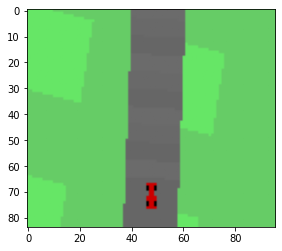

In [4]:
# from gym.envs.box2d import CarRacing
env = gnwrapper.Animation(CarRacing())
env = CarRacing()

env.reset()
env.render()
im = env.render("state_pixels")

def state_image_preprocess(state_image):
    # crop image
    state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)

# plt.imshow(im)
state_image_preprocess(im).shape
plt.imshow(state_image_preprocess(im).cpu().squeeze(0).permute(1, 2, 0).numpy())

Track generation: 1101..1380 -> 279-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:427: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


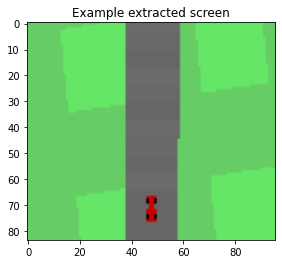

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# def get_screen():
#     # Returned screen requested by gym is 400x600x3, but is sometimes larger
#     # such as 800x1200x3. Transpose it into torch order (CHW).
#     state_image = env.render(mode='rgb_array').transpose((2, 0, 1))
#     state_image = state_image[0:84, :, :]
#     state_image = state_image.transpose((2,0,1))
#     # to torch
#     state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
#     state_image = torch.from_numpy(state_image)
#     return resize(state_image).unsqueeze(0).to(device)
#     # Cart is in the lower half, so strip off the top and bottom of the screen
#     _, screen_height, screen_width = screen.shape
#     screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
#     view_width = int(screen_width * 0.6)
#     cart_location = get_cart_location(screen_width)
#     if cart_location < view_width // 2:
#         slice_range = slice(view_width)
#     elif cart_location > (screen_width - view_width // 2):
#         slice_range = slice(-view_width, None)
#     else:
#         slice_range = slice(cart_location - view_width // 2,
#                             cart_location + view_width // 2)
#     # Strip off the edges, so that we have a square image centered on a cart
#     screen = screen[:, :, slice_range]
#     # Convert to float, rescale, convert to torch tensor
#     # (this doesn't require a copy)
#     screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
#     screen = torch.from_numpy(screen)
#     # Resize, and add a batch dimension (BCHW)
#     return resize(screen).unsqueeze(0).to(device)


def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    state_image = env.render(mode='state_pixels')
    state_image = state_image[0:84, :, :]
    state_image = state_image.transpose((2,0,1))
    # to torch
    state_image = np.ascontiguousarray(state_image, dtype=np.float32) / 255
    state_image = torch.from_numpy(state_image)
    return state_image.unsqueeze(0).to(device)


    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title('Example extracted screen')
plt.show()

## TRain old

In [11]:
env.actions

[array([-1.,  0.,  0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0. , 0. , 0.8], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
# n_actions = env.action_space.n
n_actions = len(env.actions)

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:413: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
memory.position

0

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [13]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    debug=False
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    if debug:
        print("action_batch", action_batch.size())
        print("reward_batch", reward_batch.size())
        print("state_batch", state_batch.size())
        print("state_action_values", state_action_values.size())
        print("non_final_next_states", non_final_next_states.size())
        print("expected_state_action_values", expected_state_action_values.size())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
optimize_model()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




In [14]:

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

import numpy as np
import random
import math
import glob
import io
import os
import cv2
import base64
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
from datetime import datetime

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
# import wandb
import wandb
import time

# record gameplay video
# display = Display(visible=0, size=(1400, 900))
# display.start()

DEBUG               = False
NUM_OF_EPISODES     = 2
NUM_OF_STEPS        = 100
LOG_VIDEO_EPISODES  = 2
WANDB_ID            = "sexyid123_new2"
WNDB_NAME           = "Test_bruuuu_new_new2"
LOAD_SAVED_MODEL    = False
MODEL_SAVE_NAME     = "DQN_test_model"
OPTIMIZER_SAVE_NAME = "DQN_test_optimizer"
SAVED_MODEL_VERSION = "latest"


# wnadb api key
# 00d5bfbd342bb73d5aaf4f2833436d20457ef040
os.environ["WANDB_ENTITY"]  = "andreas_giannoutsos"
os.environ["WANDB_PROJECT"] = "gym_car_racer"
os.environ["WANDB_RESUME"]  = "allow"
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# load model
if LOAD_SAVED_MODEL:
    try:
        model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':'+SAVED_MODEL_VERSION, type='model')
        artifact_dir = model_artifact.download()
        saved_model = torch.load(artifact_dir+"/"+MODEL_SAVE_NAME+".pth")
        saved_optimizer = torch.load(artifact_dir+"/"+OPTIMIZER_SAVE_NAME+".pth")
    except:
        print("no model found")

env = CarRacing()

for i_episode in range(NUM_OF_EPISODES):

    # Initialize the environment and state    
    if (i_episode % LOG_VIDEO_EPISODES == 0):
        env = gym.wrappers.Monitor(CarRacing(), './video', force=True)
    else:
        env = CarRacing()
        
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in range(NUM_OF_STEPS):

        ################# Select and perform an action ##################
        fw_start = time.time() 
        action = select_action(state)
        fw_end = time.time() 
        #################################################################


        ########################## render step ##########################
        render_start = time.time() 
        _, reward, done, _ = env.step(env.actions[action.item()])
        render_end = time.time()
        #################################################################


        ####################### Observe new state #######################
        reward = torch.tensor([reward], device=device)
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        next_state_time = time.time() 
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        #################################################################


        #################################################################
        # Perform one step of the optimization (on the target network) ##
        optimize_model()
        optimize_time = time.time() 
        #################################################################

        if DEBUG:
            print("step ", t)
            print("fw time ",fw_end- fw_start)
            print("render time ", render_end-render_start)
            print("next state time ", next_state_time- render_end)
            print("otpimize_time ", optimize_time- next_state_time)
        if done:
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    env.close() 

    # render gameplay video and save model checkpoint
    if (i_episode % LOG_VIDEO_EPISODES == 0):
        
        # Save your model and optimizer
        torch.save(policy_net.state_dict(), MODEL_SAVE_NAME+".pth")
        torch.save(optimizer.state_dict(), OPTIMIZER_SAVE_NAME+".pth")
        # Save as artifact for version control.
        artifact = wandb.Artifact(MODEL_SAVE_NAME, type='model')
        artifact.add_file(MODEL_SAVE_NAME+".pth")
        artifact.add_file(OPTIMIZER_SAVE_NAME+".pth")
        wandb.log_artifact(artifact)
        # run.join()


        mp4list = glob.glob('video/*.mp4')
        print(mp4list)
        if len(mp4list) > 0:
            print(len(mp4list))
            mp4 = mp4list[-1]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)

            # log gameplay video in wandb
            wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

            # display gameplay video
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
            print("Episode ",i_episode)

print('Complete')
# env.render()
# env.close()
# plt.ioff()
# plt.show()

Episode  0
Track generation: 1035..1297 -> 262-tiles track


/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Complete


## train new 

In [33]:
import io
import pathlib
import time
import warnings
from typing import Any, Dict, Optional, Tuple, Type, Union, Callable

import gym
import numpy as np
import torch as th

from stable_baselines3.common import logger
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import ActionNoise
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.save_util import load_from_pkl, save_to_pkl
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, RolloutReturn
Schedule = Callable[[float], float]
from stable_baselines3.common.utils import safe_mean
from stable_baselines3.common.vec_env import VecEnv


class OffPolicyAlgorithm(BaseAlgorithm):
    """
    The base for Off-Policy algorithms (ex: SAC/TD3)
    :param policy: Policy object
    :param env: The environment to learn from
                (if registered in Gym, can be str. Can be None for loading trained models)
    :param policy_base: The base policy used by this method
    :param learning_rate: learning rate for the optimizer,
        it can be a function of the current progress remaining (from 1 to 0)
    :param buffer_size: size of the replay buffer
    :param learning_starts: how many steps of the model to collect transitions for before learning starts
    :param batch_size: Minibatch size for each gradient update
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1)
    :param gamma: the discount factor
    :param train_freq: Update the model every ``train_freq`` steps. Set to `-1` to disable.
    :param gradient_steps: How many gradient steps to do after each rollout
        (see ``train_freq`` and ``n_episodes_rollout``)
        Set to ``-1`` means to do as many gradient steps as steps done in the environment
        during the rollout.
    :param n_episodes_rollout: Update the model every ``n_episodes_rollout`` episodes.
        Note that this cannot be used at the same time as ``train_freq``. Set to `-1` to disable.
    :param action_noise: the action noise type (None by default), this can help
        for hard exploration problem. Cf common.noise for the different action noise type.
    :param optimize_memory_usage: Enable a memory efficient variant of the replay buffer
        at a cost of more complexity.
        See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
    :param policy_kwargs: Additional arguments to be passed to the policy on creation
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param verbose: The verbosity level: 0 none, 1 training information, 2 debug
    :param device: Device on which the code should run.
        By default, it will try to use a Cuda compatible device and fallback to cpu
        if it is not possible.
    :param support_multi_env: Whether the algorithm supports training
        with multiple environments (as in A2C)
    :param create_eval_env: Whether to create a second environment that will be
        used for evaluating the agent periodically. (Only available when passing string for the environment)
    :param monitor_wrapper: When creating an environment, whether to wrap it
        or not in a Monitor wrapper.
    :param seed: Seed for the pseudo random generators
    :param use_sde: Whether to use State Dependent Exploration (SDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param use_sde_at_warmup: Whether to use gSDE instead of uniform sampling
        during the warm up phase (before learning starts)
    :param sde_support: Whether the model support gSDE or not
    :param remove_time_limit_termination: Remove terminations (dones) that are due to time limit.
        See https://github.com/hill-a/stable-baselines/issues/863
    :param supported_action_spaces: The action spaces supported by the algorithm.
    """

    def __init__(
        self,
        policy: Type[BasePolicy],
        env: Union[GymEnv, str],
        policy_base: Type[BasePolicy],
        learning_rate: Union[float, Schedule],
        buffer_size: int = int(1e6),
        learning_starts: int = 100,
        batch_size: int = 256,
        tau: float = 0.005,
        gamma: float = 0.99,
        train_freq: int = 1,
        gradient_steps: int = 1,
        n_episodes_rollout: int = -1,
        action_noise: Optional[ActionNoise] = None,
        optimize_memory_usage: bool = False,
        policy_kwargs: Dict[str, Any] = None,
        tensorboard_log: Optional[str] = None,
        verbose: int = 0,
        device: Union[th.device, str] = "auto",
        support_multi_env: bool = False,
        create_eval_env: bool = False,
        monitor_wrapper: bool = True,
        seed: Optional[int] = None,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        use_sde_at_warmup: bool = False,
        sde_support: bool = True,
        remove_time_limit_termination: bool = False,
        supported_action_spaces: Optional[Tuple[gym.spaces.Space, ...]] = None,
    ):

        super(OffPolicyAlgorithm, self).__init__(
            policy=policy,
            env=env,
            policy_base=policy_base,
            learning_rate=learning_rate,
            policy_kwargs=policy_kwargs,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            device=device,
            support_multi_env=support_multi_env,
            create_eval_env=create_eval_env,
            monitor_wrapper=monitor_wrapper,
            seed=seed,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            supported_action_spaces=supported_action_spaces,
        )
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.learning_starts = learning_starts
        self.tau = tau
        self.gamma = gamma
        self.train_freq = train_freq
        self.gradient_steps = gradient_steps
        self.n_episodes_rollout = n_episodes_rollout
        self.action_noise = action_noise
        self.optimize_memory_usage = optimize_memory_usage

        # Remove terminations (dones) that are due to time limit
        # see https://github.com/hill-a/stable-baselines/issues/863
        self.remove_time_limit_termination = remove_time_limit_termination

        if train_freq > 0 and n_episodes_rollout > 0:
            warnings.warn(
                "You passed a positive value for `train_freq` and `n_episodes_rollout`."
                "Please make sure this is intended. "
                "The agent will collect data by stepping in the environment "
                "until both conditions are true: "
                "`number of steps in the env` >= `train_freq` and "
                "`number of episodes` > `n_episodes_rollout`"
            )

        self.actor = None  # type: Optional[th.nn.Module]
        self.replay_buffer = None  # type: Optional[ReplayBuffer]
        # Update policy keyword arguments
        if sde_support:
            self.policy_kwargs["use_sde"] = self.use_sde
        # For gSDE only
        self.use_sde_at_warmup = use_sde_at_warmup

    def _setup_model(self) -> None:
        self._setup_lr_schedule()
        self.set_random_seed(self.seed)
        self.replay_buffer = ReplayBuffer(
            self.buffer_size,
            self.observation_space,
            self.action_space,
            self.device,
            optimize_memory_usage=self.optimize_memory_usage,
        )
        self.policy = self.policy_class(
            self.observation_space,
            self.action_space,
            self.lr_schedule,
            **self.policy_kwargs  # pytype:disable=not-instantiable
        )
        self.policy = self.policy.to(self.device)

    def save_replay_buffer(self, path: Union[str, pathlib.Path, io.BufferedIOBase]) -> None:
        """
        Save the replay buffer as a pickle file.
        :param path: Path to the file where the replay buffer should be saved.
            if path is a str or pathlib.Path, the path is automatically created if necessary.
        """
        assert self.replay_buffer is not None, "The replay buffer is not defined"
        save_to_pkl(path, self.replay_buffer, self.verbose)

    def load_replay_buffer(self, path: Union[str, pathlib.Path, io.BufferedIOBase]) -> None:
        """
        Load a replay buffer from a pickle file.
        :param path: Path to the pickled replay buffer.
        """
        self.replay_buffer = load_from_pkl(path, self.verbose)
        assert isinstance(self.replay_buffer, ReplayBuffer), "The replay buffer must inherit from ReplayBuffer class"

    def _setup_learn(
        self,
        total_timesteps: int,
        eval_env: Optional[GymEnv],
        callback: MaybeCallback = None,
        eval_freq: int = 10000,
        n_eval_episodes: int = 5,
        log_path: Optional[str] = None,
        reset_num_timesteps: bool = True,
        tb_log_name: str = "run",
    ) -> Tuple[int, BaseCallback]:
        """
        cf `BaseAlgorithm`.
        """
        # Prevent continuity issue by truncating trajectory
        # when using memory efficient replay buffer
        # see https://github.com/DLR-RM/stable-baselines3/issues/46
        truncate_last_traj = (
            self.optimize_memory_usage
            and reset_num_timesteps
            and self.replay_buffer is not None
            and (self.replay_buffer.full or self.replay_buffer.pos > 0)
        )

        if truncate_last_traj:
            warnings.warn(
                "The last trajectory in the replay buffer will be truncated, "
                "see https://github.com/DLR-RM/stable-baselines3/issues/46."
                "You should use `reset_num_timesteps=False` or `optimize_memory_usage=False`"
                "to avoid that issue."
            )
            # Go to the previous index
            pos = (self.replay_buffer.pos - 1) % self.replay_buffer.buffer_size
            self.replay_buffer.dones[pos] = True

        return super()._setup_learn(
            total_timesteps, eval_env, callback, eval_freq, n_eval_episodes, log_path, reset_num_timesteps, tb_log_name
        )

    def learn(
        self,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 4,
        eval_env: Optional[GymEnv] = None,
        eval_freq: int = -1,
        n_eval_episodes: int = 5,
        tb_log_name: str = "run",
        eval_log_path: Optional[str] = None,
        reset_num_timesteps: bool = True,
    ) -> "OffPolicyAlgorithm":

        total_timesteps, callback = self._setup_learn(
            total_timesteps, eval_env, callback, eval_freq, n_eval_episodes, eval_log_path, reset_num_timesteps, tb_log_name
        )

        callback.on_training_start(locals(), globals())

        while self.num_timesteps < total_timesteps:

            rollout = self.collect_rollouts(
                self.env,
                n_episodes=self.n_episodes_rollout,
                n_steps=self.train_freq,
                action_noise=self.action_noise,
                callback=callback,
                learning_starts=self.learning_starts,
                replay_buffer=self.replay_buffer,
                log_interval=log_interval,
            )

            if rollout.continue_training is False:
                break

            if self.num_timesteps > 0 and self.num_timesteps > self.learning_starts:
                # If no `gradient_steps` is specified,
                # do as many gradients steps as steps performed during the rollout
                gradient_steps = self.gradient_steps if self.gradient_steps > 0 else rollout.episode_timesteps
                self.train(batch_size=self.batch_size, gradient_steps=gradient_steps)

        callback.on_training_end()

        return self

    def train(self, gradient_steps: int, batch_size: int) -> None:
        """
        Sample the replay buffer and do the updates
        (gradient descent and update target networks)
        """
        raise NotImplementedError()

    def _sample_action(
        self, learning_starts: int, action_noise: Optional[ActionNoise] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Sample an action according to the exploration policy.
        This is either done by sampling the probability distribution of the policy,
        or sampling a random action (from a uniform distribution over the action space)
        or by adding noise to the deterministic output.
        :param action_noise: Action noise that will be used for exploration
            Required for deterministic policy (e.g. TD3). This can also be used
            in addition to the stochastic policy for SAC.
        :param learning_starts: Number of steps before learning for the warm-up phase.
        :return: action to take in the environment
            and scaled action that will be stored in the replay buffer.
            The two differs when the action space is not normalized (bounds are not [-1, 1]).
        """
        # Select action randomly or according to policy
        if self.num_timesteps < learning_starts and not (self.use_sde and self.use_sde_at_warmup):
            # Warmup phase
            unscaled_action = np.array([self.action_space.sample()])
        else:
            # Note: when using continuous actions,
            # we assume that the policy uses tanh to scale the action
            # We use non-deterministic action in the case of SAC, for TD3, it does not matter
            unscaled_action, _ = self.predict(self._last_obs, deterministic=False)

        # Rescale the action from [low, high] to [-1, 1]
        if isinstance(self.action_space, gym.spaces.Box):
            scaled_action = self.policy.scale_action(unscaled_action)

            # Add noise to the action (improve exploration)
            if action_noise is not None:
                scaled_action = np.clip(scaled_action + action_noise(), -1, 1)

            # We store the scaled action in the buffer
            buffer_action = scaled_action
            action = self.policy.unscale_action(scaled_action)
        else:
            # Discrete case, no need to normalize or clip
            buffer_action = unscaled_action
            action = buffer_action
        return action, buffer_action

    def _dump_logs(self) -> None:
        """
        Write log.
        """
        fps = int(self.num_timesteps / (time.time() - self.start_time))
        logger.record("time/episodes", self._episode_num, exclude="tensorboard")
        if len(self.ep_info_buffer) > 0 and len(self.ep_info_buffer[0]) > 0:
            logger.record("rollout/ep_rew_mean", safe_mean([ep_info["r"] for ep_info in self.ep_info_buffer]))
            logger.record("rollout/ep_len_mean", safe_mean([ep_info["l"] for ep_info in self.ep_info_buffer]))
        logger.record("time/fps", fps)
        logger.record("time/time_elapsed", int(time.time() - self.start_time), exclude="tensorboard")
        logger.record("time/total timesteps", self.num_timesteps, exclude="tensorboard")
        if self.use_sde:
            logger.record("train/std", (self.actor.get_std()).mean().item())

        if len(self.ep_success_buffer) > 0:
            logger.record("rollout/success rate", safe_mean(self.ep_success_buffer))
        # Pass the number of timesteps for tensorboard
        logger.dump(step=self.num_timesteps)

    def _on_step(self) -> None:
        """
        Method called after each step in the environment.
        It is meant to trigger DQN target network update
        but can be used for other purposes
        """
        pass

    def collect_rollouts(
        self,
        env: VecEnv,
        callback: BaseCallback,
        n_episodes: int = 1,
        n_steps: int = -1,
        action_noise: Optional[ActionNoise] = None,
        learning_starts: int = 0,
        replay_buffer: Optional[ReplayBuffer] = None,
        log_interval: Optional[int] = None,
    ) -> RolloutReturn:
        """
        Collect experiences and store them into a ``ReplayBuffer``.
        :param env: The training environment
        :param callback: Callback that will be called at each step
            (and at the beginning and end of the rollout)
        :param n_episodes: Number of episodes to use to collect rollout data
            You can also specify a ``n_steps`` instead
        :param n_steps: Number of steps to use to collect rollout data
            You can also specify a ``n_episodes`` instead.
        :param action_noise: Action noise that will be used for exploration
            Required for deterministic policy (e.g. TD3). This can also be used
            in addition to the stochastic policy for SAC.
        :param learning_starts: Number of steps before learning for the warm-up phase.
        :param replay_buffer:
        :param log_interval: Log data every ``log_interval`` episodes
        :return:
        """
        episode_rewards, total_timesteps = [], []
        total_steps, total_episodes = 0, 0

        assert isinstance(env, VecEnv), "You must pass a VecEnv"
        assert env.num_envs == 1, "OffPolicyAlgorithm only support single environment"

        if self.use_sde:
            self.actor.reset_noise()

        callback.on_rollout_start()
        continue_training = True

        while total_steps < n_steps or total_episodes < n_episodes:
            done = False
            episode_reward, episode_timesteps = 0.0, 0

            while not done:

                if self.use_sde and self.sde_sample_freq > 0 and total_steps % self.sde_sample_freq == 0:
                    # Sample a new noise matrix
                    self.actor.reset_noise()

                # Select action randomly or according to policy
                action, buffer_action = self._sample_action(learning_starts, action_noise)

                # Rescale and perform action
                new_obs, reward, done, infos = env.step(action)

                self.num_timesteps += 1
                episode_timesteps += 1
                total_steps += 1

                # Give access to local variables
                callback.update_locals(locals())
                # Only stop training if return value is False, not when it is None.
                if callback.on_step() is False:
                    return RolloutReturn(0.0, total_steps, total_episodes, continue_training=False)

                episode_reward += reward

                # Retrieve reward and episode length if using Monitor wrapper
                self._update_info_buffer(infos, done)

                # Store data in replay buffer
                if replay_buffer is not None:
                    # Store only the unnormalized version
                    if self._vec_normalize_env is not None:
                        new_obs_ = self._vec_normalize_env.get_original_obs()
                        reward_ = self._vec_normalize_env.get_original_reward()
                    else:
                        # Avoid changing the original ones
                        self._last_original_obs, new_obs_, reward_ = self._last_obs, new_obs, reward

                    replay_buffer.add(self._last_original_obs, new_obs_, buffer_action, reward_, done)

                self._last_obs = new_obs
                # Save the unnormalized observation
                if self._vec_normalize_env is not None:
                    self._last_original_obs = new_obs_

                self._update_current_progress_remaining(self.num_timesteps, self._total_timesteps)

                # For DQN, check if the target network should be updated
                # and update the exploration schedule
                # For SAC/TD3, the update is done as the same time as the gradient update
                # see https://github.com/hill-a/stable-baselines/issues/900
                self._on_step()

                if 0 < n_steps <= total_steps:
                    break

            if done:
                total_episodes += 1
                self._episode_num += 1
                episode_rewards.append(episode_reward)
                total_timesteps.append(episode_timesteps)

                if action_noise is not None:
                    action_noise.reset()

                # Log training infos
                if log_interval is not None and self._episode_num % log_interval == 0:
                    self._dump_logs()

        mean_reward = np.mean(episode_rewards) if total_episodes > 0 else 0.0

        callback.on_rollout_end()

        return RolloutReturn(mean_reward, total_steps, total_episodes, continue_training)

In [36]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union, Callable

import gym
import numpy as np
import torch as th
from torch.nn import functional as F

from stable_baselines3.common import logger
# from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
Schedule = Callable[[float], float]
from stable_baselines3.common.utils import get_linear_fn, is_vectorized_observation, polyak_update
from stable_baselines3.dqn.policies import DQNPolicy


class DQN(OffPolicyAlgorithm):
    """
    Deep Q-Network (DQN)
    Paper: https://arxiv.org/abs/1312.5602, https://www.nature.com/articles/nature14236
    Default hyperparameters are taken from the nature paper,
    except for the optimizer and learning rate that were taken from Stable Baselines defaults.
    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param buffer_size: size of the replay buffer
    :param learning_starts: how many steps of the model to collect transitions for before learning starts
    :param batch_size: Minibatch size for each gradient update
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) default 1 for hard update
    :param gamma: the discount factor
    :param train_freq: Update the model every ``train_freq`` steps. Set to `-1` to disable.
    :param gradient_steps: How many gradient steps to do after each rollout
        (see ``train_freq`` and ``n_episodes_rollout``)
        Set to ``-1`` means to do as many gradient steps as steps done in the environment
        during the rollout.
    :param n_episodes_rollout: Update the model every ``n_episodes_rollout`` episodes.
        Note that this cannot be used at the same time as ``train_freq``. Set to `-1` to disable.
    :param optimize_memory_usage: Enable a memory efficient variant of the replay buffer
        at a cost of more complexity.
        See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
    :param target_update_interval: update the target network every ``target_update_interval``
        environment steps.
    :param exploration_fraction: fraction of entire training period over which the exploration rate is reduced
    :param exploration_initial_eps: initial value of random action probability
    :param exploration_final_eps: final value of random action probability
    :param max_grad_norm: The maximum value for the gradient clipping
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param create_eval_env: Whether to create a second environment that will be
        used for evaluating the agent periodically. (Only available when passing string for the environment)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: the verbosity level: 0 no output, 1 info, 2 debug
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    def __init__(
        self,
        policy: Union[str, Type[DQNPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 1e-4,
        buffer_size: int = 1000000,
        learning_starts: int = 50000,
        batch_size: Optional[int] = 32,
        tau: float = 1.0,
        gamma: float = 0.99,
        train_freq: int = 4,
        gradient_steps: int = 1,
        n_episodes_rollout: int = -1,
        optimize_memory_usage: bool = False,
        target_update_interval: int = 10000,
        exploration_fraction: float = 0.1,
        exploration_initial_eps: float = 1.0,
        exploration_final_eps: float = 0.05,
        max_grad_norm: float = 10,
        tensorboard_log: Optional[str] = None,
        create_eval_env: bool = False,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        print("naiii")
        super(DQN, self).__init__(
            policy,
            env,
            DQNPolicy,
            learning_rate,
            buffer_size,
            learning_starts,
            batch_size,
            tau,
            gamma,
            train_freq,
            gradient_steps,
            n_episodes_rollout,
            action_noise=None,  # No action noise
            policy_kwargs=policy_kwargs,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            device=device,
            create_eval_env=create_eval_env,
            seed=seed,
            sde_support=False,
            optimize_memory_usage=optimize_memory_usage,
            supported_action_spaces=(gym.spaces.Discrete,),
        )

        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.exploration_fraction = exploration_fraction
        self.target_update_interval = target_update_interval
        self.max_grad_norm = max_grad_norm
        # "epsilon" for the epsilon-greedy exploration
        self.exploration_rate = 0.0
        # Linear schedule will be defined in `_setup_model()`
        self.exploration_schedule = None
        self.q_net, self.q_net_target = None, None

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        super(DQN, self)._setup_model()
        self._create_aliases()
        self.exploration_schedule = get_linear_fn(
            self.exploration_initial_eps, self.exploration_final_eps, self.exploration_fraction
        )

    def _create_aliases(self) -> None:
        self.q_net = self.policy.q_net
        self.q_net_target = self.policy.q_net_target

    def _on_step(self) -> None:
        """
        Update the exploration rate and target network if needed.
        This method is called in ``collect_rollouts()`` after each step in the environment.
        """
        if self.num_timesteps % self.target_update_interval == 0:
            polyak_update(self.q_net.parameters(), self.q_net_target.parameters(), self.tau)

        self.exploration_rate = self.exploration_schedule(self._current_progress_remaining)
        logger.record("rollout/exploration rate", self.exploration_rate)

    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for gradient_step in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Follow greedy policy: use the one with the highest value
                next_q_values, _ = next_q_values.max(dim=1)
                # Avoid potential broadcast issue
                next_q_values = next_q_values.reshape(-1, 1)
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Compute Huber loss (less sensitive to outliers)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)
            losses.append(loss.item())

            # Optimize the policy
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        logger.record("train/loss", np.mean(losses))

    def predict(
        self,
        observation: np.ndarray,
        state: Optional[np.ndarray] = None,
        mask: Optional[np.ndarray] = None,
        deterministic: bool = False,
    ) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Overrides the base_class predict function to include epsilon-greedy exploration.
        :param observation: the input observation
        :param state: The last states (can be None, used in recurrent policies)
        :param mask: The last masks (can be None, used in recurrent policies)
        :param deterministic: Whether or not to return deterministic actions.
        :return: the model's action and the next state
            (used in recurrent policies)
        """
        if not deterministic and np.random.rand() < self.exploration_rate:
            if is_vectorized_observation(observation, self.observation_space):
                n_batch = observation.shape[0]
                action = np.array([self.action_space.sample() for _ in range(n_batch)])
            else:
                action = np.array(self.action_space.sample())
        else:
            action, state = self.policy.predict(observation, state, mask, deterministic)
        return action, state

    def learn(
        self,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 4,
        eval_env: Optional[GymEnv] = None,
        eval_freq: int = -1,
        n_eval_episodes: int = 5,
        tb_log_name: str = "DQN",
        eval_log_path: Optional[str] = None,
        reset_num_timesteps: bool = True,
    ) -> OffPolicyAlgorithm:

        return super(DQN, self).learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            eval_env=eval_env,
            eval_freq=eval_freq,
            n_eval_episodes=n_eval_episodes,
            tb_log_name=tb_log_name,
            eval_log_path=eval_log_path,
            reset_num_timesteps=reset_num_timesteps,
        )

    def _excluded_save_params(self) -> List[str]:
        return super(DQN, self)._excluded_save_params() + ["q_net", "q_net_target"]

    def _get_torch_save_params(self) -> Tuple[List[str], List[str]]:
        state_dicts = ["policy", "policy.optimizer"]

        return state_dicts, []

## επιτελοθσ

In [7]:
np.__version__

'1.15.4'

In [9]:
from stable_baselines3.common.callbacks import BaseCallback


class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        # print("pipaa", self.num_timesteps)
        # print(self.locals["done"])
        if self.locals["done"][0]:
            print(self.locals)
            print("PIPAAAAAAAAAAAAAAAAA", self.locals["total_episodes"])
        
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

In [12]:
import gym
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3.dqn import CnnPolicy

from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
event_callback = EveryNTimesteps(n_steps=500, callback=checkpoint_on_event)


# env = gym.wrappers.Monitor(CarRacing(), './video', force=True)
# env = gnwrapper.Animation(CarRacing())

env = CarRacing()


model = DQN(CnnPolicy, CarRacing(100), verbose=1, buffer_size=1000, learning_starts=1000)
model.learn(total_timesteps=500, log_interval=4, callback=CustomCallback())
model.save("dqn_pendulum")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_pendulum")

# obs = env.reset()
# while True:
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, done, info = env.step(action)
#     env.render()
#     if done:
#       obs = env.reset()

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Track generation: 1164..1469 -> 305-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:427: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Track generation: 1074..1347 -> 273-tiles track
{'reset_num_timesteps': True, 'eval_log_path': None, 'tb_log_name': 'DQN', 'n_eval_episodes': 5, 'eval_freq': -1, 'eval_env': None, 'log_interval': 4, 'callback': <__main__.CustomCallback object at 0x7fc875d6a320>, 'total_timesteps': [], 'self': <stable_baselines3.dqn.dqn.DQN object at 0x7fc875d6a940>, 'infos': [{'terminal_observation': array([[[102, 204, 102],
        [102, 204, 102],
        [102, 204, 102],
        ...,
        [102, 204, 102],
        [102, 204, 102],
        [102, 204, 102]],

       [[102, 204, 102],
        [102, 204, 102],
        [102, 204, 102],
        ...,
        [102, 204, 102],
        [102, 204, 102],
        [102, 204, 102]],

       [[102, 204, 102],
        [102, 204, 102],
        [102, 204, 102],
        ...,
        [102, 204, 102],
        [102, 204, 102],
        [102, 204, 102]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0

In [29]:
env.observation_space

Box(0, 255, (96, 96, 3), uint8)

In [11]:
import gym
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy

env = gym.make('CartPole-v0')

model = DQN(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1, log_interval=4)
model.save("dqn_pendulum")

del model # remove to demonstrate saving and loading

model = DQN.load("dqn_pendulum")

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()

Using cpu device
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: ignored

In [23]:
import gym

from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
env = make_vec_env(CarRacing, n_envs=4)
# env = gym.make("CarRacing-v0")


model = PPO(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1)
model.save("ppo_cartpole")

del model # remove to demonstrate saving and loading

model = PPO.load("ppo_cartpole")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()


Using cpu device
Wrapping the env in a VecTransposeImage.
Track generation: 1111..1392 -> 281-tiles track
Track generation: 1184..1484 -> 300-tiles track


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Track generation: 1130..1419 -> 289-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1156..1449 -> 293-tiles track
Track generation: 1106..1387 -> 281-tiles track


KeyboardInterrupt: ignored

In [ ]:
wandb.init(resume=WANDB_ID)
wandb.run.name = WNDB_NAME

# load model
model_artifact = wandb.use_artifact(MODEL_SAVE_NAME+':latest', type='model')
artifact_dir = model_artifact.download()
saved_model = torch.load(artifact_dir+"/"+MODEL_SAVE_NAME+".pth")
saved_optimizer = torch.load(artifact_dir+"/"+OPTIMIZER_SAVE_NAME+".pth")

_runtime,22077
_timestamp,1613778608
_step,73


In [ ]:
artifact_dir
saved_model = torch.load(artifact_dir+"/"+MODEL_SAVE_NAME+".pth")
saved_optimizer = torch.load(artifact_dir+"/"+OPTIMIZER_SAVE_NAME+".pth")


'./artifacts/DQN_test_model:v0'

In [ ]:
# env = gnwrapper.Animation(gym.make('CartPole-v1'))
env = gym.make('CartPole-v1')

obs = env.reset()

# for _ in range(100):
#     print(_)
#     action = select_action(get_screen())
#     next_obs, reward, done, info = env.step(action)
#     env.render()

#     obs = next_obs
#     if done:
#         obs = env.reset()
#         print(_)
total_steps = 0
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    # env = gnwrapper.Animation(gym.make('CartPole-v1'))
    env = gym.make('CartPole-v1')

    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    print(i_episode)
    for t in count():
        total_steps+=1
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

env.close()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()
print("total steps ", total_steps)

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. "Older" target_net is also used in optimization to compute the
expected Q values; it is updated occasionally to keep it current.


